# Championship 2023-2024 Predictions

In [91]:
# import data
import pandas as pd
import numpy as np

df = pd.read_csv('epl/E0 2.csv')
df.tail()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
183,E0,27/12/2023,19:30,Brentford,Wolves,1,4,A,1,3,...,1.79,-0.25,1.94,1.99,1.93,1.98,1.99,2.05,1.89,1.97
184,E0,27/12/2023,19:30,Chelsea,Crystal Palace,2,1,H,1,1,...,1.90,-0.75,2.07,1.86,2.07,1.86,2.08,1.92,1.98,1.86
185,E0,27/12/2023,20:15,Everton,Man City,1,3,A,1,0,...,1.92,1.00,1.68,2.15,1.73,2.23,1.89,2.25,1.78,2.09
186,E0,28/12/2023,19:30,Brighton,Tottenham,4,2,H,2,0,...,2.84,0.00,1.86,2.04,1.88,2.05,1.95,2.08,1.88,1.99
187,E0,28/12/2023,20:15,Arsenal,West Ham,0,2,A,0,1,...,2.48,-1.50,1.78,2.03,1.83,2.08,1.90,2.13,1.83,2.04


In [92]:
## Data Cleaning

In [93]:
# steps:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the results of the checks
missing_values, duplicate_rows

(Div         0
 Date        0
 Time        0
 HomeTeam    0
 AwayTeam    0
            ..
 PCAHA       0
 MaxCAHH     1
 MaxCAHA     1
 AvgCAHH     0
 AvgCAHA     0
 Length: 106, dtype: int64,
 0)

In [94]:
# Dropping columns with a high number of missing values or irrelevant to our analysis
irrelevant_columns = df.columns[df.isnull().sum() > (0.5 * len(df))]  # Columns with more than 50% missing values
df_cleaned = df.drop(columns=irrelevant_columns)

# Convert 'Date' to datetime
#df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d/%m/%Y')

# Fill missing values in other relevant columns with appropriate values (like median or mode)
# For numerical columns, we use median and for categorical, we use mode
for column in df_cleaned.columns:
    if df_cleaned[column].dtype == 'object':
        df_cleaned[column].fillna(df_cleaned[column].mode()[0], inplace=True)
    else:
        df_cleaned[column].fillna(df_cleaned[column].median(), inplace=True)

# Recheck for missing values
remaining_missing_values = df_cleaned.isnull().sum().sum()

# Basic information after cleaning
remaining_missing_values, df_cleaned.info()

df_cleaned.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Columns: 106 entries, Div to AvgCAHA
dtypes: float64(82), int64(16), object(8)
memory usage: 155.8+ KB


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,2.28,1.50,1.95,1.98,1.95,1.97,2.01,2.00,1.92,1.95
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,2.63,-2.00,1.95,1.98,1.93,1.97,2.01,2.09,1.95,1.92
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,2.12,0.00,2.02,1.91,2.01,1.92,2.06,1.96,1.96,1.91
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,2.48,-1.75,2.01,1.92,2.00,1.91,2.14,1.93,2.00,1.86
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,1.71,-0.25,2.06,1.87,2.04,1.88,2.08,1.99,1.98,1.88


## Feature engineering

### steps:
* Encode Team Names: Use label encoding for 'HomeTeam' and 'AwayTeam'. This will convert team names into numeric values, making them usable for the model.

* Recent Form: Calculate the recent form for each team based on the last 5 matches. We'll use the 'FTR' column to determine wins (W), losses (L), and draws (D). This feature will provide insight into the current performance of the teams.

* Average Goals per Game: Compute the average goals scored per game for both home and away teams. This feature helps understand the offensive strength of the teams.

* Team Points: Calculate the total points accumulated by each team so far in the season. Points are awarded based on wins (3 points), draws (1 point), and losses (0 points).

* Head-to-Head Statistics: Analyze the outcomes of matches between the same pairs of teams earlier in the season.

* Other Statistical Features: Depending on the data available, we can include additional features like average possession, number of shots on target, defensive strength, etc.

In [95]:
# Import the LabelEncoder class from the sklearn library
from sklearn.preprocessing import LabelEncoder

# Encode the team names
label_encoder = LabelEncoder()
df_cleaned['HomeTeamEncoded'] = label_encoder.fit_transform(df_cleaned['HomeTeam'])
df_cleaned['AwayTeamEncoded'] = label_encoder.transform(df_cleaned['AwayTeam'])


### Recent Form

In [96]:
# function to calculate recent form
def calculate_form_points(team, df_cleaned, num_matches=5):
    # Filter the matches for the team
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    # Sort by date to get the most recent matches
    team_matches = team_matches.sort_values(by='Date', ascending=False)
    # Get the last 'num_matches' matches
    recent_matches = team_matches.head(num_matches)
    # Calculate form points
    form_points = 0
    for _, row in recent_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            form_points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            form_points += 3
        elif row['FTR'] == 'D':
            form_points += 1
    return form_points

# Apply the function to get recent form for each team in each match
df_cleaned['HomeTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamRecentForm'] = df_cleaned.apply(lambda x: calculate_form_points(x['AwayTeam'], df_cleaned), axis=1)

# Average Goals per Game
df_cleaned['HomeTeamAvgGoals'] = df_cleaned.groupby('HomeTeam')['FTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoals'] = df_cleaned.groupby('AwayTeam')['FTAG'].transform('mean')

# half time average goals
df_cleaned['HomeTeamAvgGoalsHT'] = df_cleaned.groupby('HomeTeam')['HTHG'].transform('mean')
df_cleaned['AwayTeamAvgGoalsHT'] = df_cleaned.groupby('AwayTeam')['HTAG'].transform('mean')




### Team Points

In [97]:
# Points will be calculated similar to form but for the whole season
def calculate_team_points(team, df_cleaned):
    team_matches = df_cleaned[(df_cleaned['HomeTeam'] == team) | (df_cleaned['AwayTeam'] == team)]
    points = 0
    for _, row in team_matches.iterrows():
        if row['HomeTeam'] == team and row['FTR'] == 'H':
            points += 3
        elif row['AwayTeam'] == team and row['FTR'] == 'A':
            points += 3
        elif row['FTR'] == 'D':
            points += 1
    return points

df_cleaned['HomeTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['HomeTeam'], df_cleaned), axis=1)
df_cleaned['AwayTeamPoints'] = df_cleaned.apply(lambda x: calculate_team_points(x['AwayTeam'], df_cleaned), axis=1)




### Head-to-Head Statistics

In [98]:
# Head-to-Head Statistics
# For simplicity, we can count the number of wins, draws, and losses in matches between the same teams
# Note: This implementation is simplified for demonstration purposes
def head_to_head_stats(home_team, away_team, df_cleaned):
    head_to_head_matches = df_cleaned[(df_cleaned['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)]
    wins = len(head_to_head_matches[head_to_head_matches['FTR'] == 'H'])
    draws = len(head_to_head_matches[head_to_head_matches['FTR'] == 'D'])
    losses = len(head_to_head_matches[head_to_head_matches['FTR'] == 'A'])
    return wins, draws, losses

# Apply the head-to-head stats function
df_cleaned['HeadToHeadWins'], df_cleaned['HeadToHeadDraws'], df_cleaned['HeadToHeadLosses'] = zip(*df_cleaned.apply(lambda x: head_to_head_stats(x['HomeTeam'], x['AwayTeam'], df_cleaned), axis=1))

In [99]:
# Calculate Home Team Win Percentage
home_team_wins = df_cleaned[df_cleaned['FTR'] == 'H'].groupby('HomeTeam').size()
total_home_matches = df_cleaned.groupby('HomeTeam').size()
home_team_win_percentage = home_team_wins / total_home_matches
# 
# Calculate Away Team Win Percentage
away_team_wins = df_cleaned[df_cleaned['FTR'] == 'A'].groupby('AwayTeam').size()
total_away_matches = df_cleaned.groupby('AwayTeam').size()
away_team_win_percentage = away_team_wins / total_away_matches
# 
# Create mappings for win percentages
home_team_win_percentage_map = home_team_win_percentage.to_dict()
away_team_win_percentage_map = away_team_win_percentage.to_dict()
# 
# Map the win percentages to the original DataFrame
df_cleaned['HomeTeamWinPercentage'] = df_cleaned['HomeTeam'].map(home_team_win_percentage_map).fillna(0)
df_cleaned['AwayTeamWinPercentage'] = df_cleaned['AwayTeam'].map(away_team_win_percentage_map).fillna(0)

# calculate the average shots on target for home and away teams
df_cleaned['HomeTeamAvgShotsOnTarget'] = df_cleaned.groupby('HomeTeam')['HST'].transform('mean')
df_cleaned['AwayTeamAvgShotsOnTarget'] = df_cleaned.groupby('AwayTeam')['AST'].transform('mean')

 
# Check the first few rows to confirm the new features
print(df_cleaned[['HomeTeam', 'HomeTeamWinPercentage', 'AwayTeam', 'AwayTeamWinPercentage','HomeTeamAvgShotsOnTarget','AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT']].head())


      HomeTeam  HomeTeamWinPercentage       AwayTeam  AwayTeamWinPercentage  \
0      Burnley               0.100000       Man City               0.600000   
1      Arsenal               0.700000  Nott'm Forest               0.200000   
2  Bournemouth               0.333333       West Ham               0.500000   
3     Brighton               0.500000          Luton               0.222222   
4      Everton               0.300000         Fulham               0.100000   

   HomeTeamAvgShotsOnTarget  AwayTeamAvgShotsOnTarget  HomeTeamAvgGoalsHT  \
0                  3.300000                  7.800000            0.400000   
1                  6.800000                  3.200000            0.800000   
2                  4.888889                  3.500000            0.444444   
3                  7.500000                  2.444444            0.900000   
4                  5.300000                  3.900000            0.500000   

   AwayTeamAvgGoalsHT  
0            0.500000  
1            0

In [100]:
df_cleaned.head()

# check for missing values
df_cleaned.isnull().sum().sum() 

0

In [101]:
# get the current position and calculate points for chelsea and the rest of the teams
def calculate_points_goals(row):
    home_points, away_points = 0, 0
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = row['FTAG'] - row['FTHG']

    if row['FTR'] == 'H':
        home_points = 3
    elif row['FTR'] == 'A':
        away_points = 3
    else:
        home_points = away_points = 1

    return pd.Series([home_points, away_points, home_goal_diff, away_goal_diff, row['FTHG'], row['FTAG']])

# List of teams
teams = df_cleaned['HomeTeam'].unique()

# Applying the function to the dataset
df_cleaned[['HomePoints', 'AwayPoints', 'HomeGoalDiff', 'AwayGoalDiff', 'HomeGoals', 'AwayGoals']] = df_cleaned.apply(calculate_points_goals, axis=1)

# Summarizing the data for each team
team_stats = pd.DataFrame(index=teams)

# Calculating total points, goal difference, and goals scored for each team
team_stats['Points'] = df_cleaned.groupby('HomeTeam')['HomePoints'].sum() + df_cleaned.groupby('AwayTeam')['AwayPoints'].sum()
team_stats['GoalDiff'] = df_cleaned.groupby('HomeTeam')['HomeGoalDiff'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoalDiff'].sum()
team_stats['GoalsScored'] = df_cleaned.groupby('HomeTeam')['HomeGoals'].sum() + df_cleaned.groupby('AwayTeam')['AwayGoals'].sum()



# Sorting the teams based on Points, Goal Difference, and Goals Scored
sorted_teams = team_stats.sort_values(by=['Points', 'GoalDiff', 'GoalsScored'], ascending=[False, False, False])


sorted_teams.head(24)


,Points,GoalDiff,GoalsScored
Liverpool,42,23,39
Arsenal,40,18,36
Aston Villa,39,15,40
Man City,37,22,43
Tottenham,36,11,39
West Ham,33,3,33
Man United,31,-4,21
Brighton,30,5,38
Newcastle,29,12,37
Everton,26,-1,24


In [102]:
df_cleaned.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HomeTeamWinPercentage,AwayTeamWinPercentage,HomeTeamAvgShotsOnTarget,AwayTeamAvgShotsOnTarget,HomePoints,AwayPoints,HomeGoalDiff,AwayGoalDiff,HomeGoals,AwayGoals
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,0.100000,0.600000,3.300000,7.800000,0,3,-3,3,0,3
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,0.700000,0.200000,6.800000,3.200000,3,0,1,-1,2,1
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,0.333333,0.500000,4.888889,3.500000,1,1,0,0,1,1
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,0.500000,0.222222,7.500000,2.444444,3,0,3,-3,4,1
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,0.300000,0.100000,5.300000,3.900000,0,3,-1,1,0,1


In [103]:
def average_goals_conceded(df, team, home_or_away):
    if home_or_away == 'home':
        # Goals conceded at home = Full Time Away Goals when this team is home
        goals_conceded = df[df['HomeTeam'] == team]['FTAG'].mean()
    else:
        # Goals conceded away = Full Time Home Goals when this team is away
        goals_conceded = df[df['AwayTeam'] == team]['FTHG'].mean()
    return goals_conceded

df_cleaned['HomeTeamAvgGoalsConceded'] = df_cleaned['HomeTeam'].apply(lambda x: average_goals_conceded(df_cleaned, x, 'home'))
df_cleaned['AwayTeamAvgGoalsConceded'] = df_cleaned['AwayTeam'].apply(lambda x: average_goals_conceded(df_cleaned, x, 'away'))


## Data Preprocessing

## Data Preprocessing
### steps:
* Scaling Numeric Features: We'll scale features like recent form, average goals, and points using StandardScaler.
* Handling Categorical Variables: We have already encoded team names. We'll ensure other categorical features, if any, are properly encoded.
* Splitting the Data: We'll split the data into training and test sets. We'll use the training set to train the model and the test set to evaluate the model's performance on unseen data.

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# select relevant columns or features
features = ['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded']
target = 'FTR'

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

## LightGBM Classifier

In [105]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Initialize the model
lgbm_model = LGBMClassifier(random_state=42)

# Train the model
lgbm_model.fit(X_train_scaled, y_train_smote)

# Evaluate the model
y_pred = lgbm_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred, zero_division=0))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 198, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [106]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(lgbm_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")

# Compare Training and Cross-Validation Accuracies
if lgbm_model.score(X_train_scaled, y_train_smote) > cv_scores.mean():
    print("The model might be overfitting.")
else:
    print("The model does not appear to be overfitting.")
    
    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 356
[LightGBM] [Info] Number of data points in the train set: 165, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [107]:

# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsConceded'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsConceded'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


print('##########################')
print('Today\'s matches')

predict_match('Fulham', 'Arsenal', lgbm_model, scaler)

predict_match('Tottenham', 'Bournemouth', lgbm_model, scaler)




##########################
Today's matches
Fulham win probability: 0.9506556594038206
Arsenal win probability: 0.022891341753655734
Draw probability: 0.026452998842523532
Tottenham win probability: 0.5641582408556733
Bournemouth win probability: 0.4312616993905559
Draw probability: 0.004580059753770734


(0.5641582408556733, 0.4312616993905559, 0.004580059753770734)

## Hyperparameter Tuning

In [108]:
from hyperopt import hp
import numpy as np
# Define the hyperparameter space
space = {
    'iterations': hp.quniform('iterations', 100, 1000, 50),
    'depth': hp.choice('depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1)
    
}


## Creating the Objective Function so that we can use it in the hyperparameter optimization


In [109]:
from hyperopt import STATUS_OK
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

def objective(params):
    params['iterations'] = int(params['iterations'])
    clf = CatBoostClassifier(**params, loss_function='MultiClass', verbose=False)
    score = cross_val_score(clf, X_train_scaled, y_train_smote, scoring='accuracy', cv=StratifiedKFold(3)).mean()
    return {'loss': -score, 'status': STATUS_OK}



In [110]:
# run the hyperparameter optimization
from hyperopt import tpe, Trials, fmin

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

100%|██████████| 10/10 [01:33<00:00,  9.32s/trial, best loss: -0.6565656565656566]


In [111]:
from sklearn.metrics import classification_report, accuracy_score

best_params = {k: int(v) if k in ['iterations', 'depth'] else v for k, v in best.items()}
final_model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)
# add early stopping to prevent overfitting, traning will stop if the validation accuracy does not improve for 50 rounds
final_model.fit(X_train_scaled, y_train_smote, eval_set=(X_test_scaled, y_test), early_stopping_rounds=50)  # early stopping to prevent overfitting

print("Best hyperparameters:", best_params)

# Evaluate the model
y_pred = final_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate Training Accuracy
y_train_pred = final_model.predict(X_train_scaled)
training_accuracy = accuracy_score(y_train_smote, y_train_pred)
print(f"Training Accuracy: {training_accuracy}")

Best hyperparameters: {'bagging_temperature': 0.7848123688037322, 'depth': 5, 'iterations': 400, 'l2_leaf_reg': 1.9082506853631251, 'learning_rate': 0.10461934433656887, 'random_strength': 0.7590054021407779}
              precision    recall  f1-score   support

           A       0.44      0.40      0.42        10
           D       0.43      0.43      0.43         7
           H       0.77      0.81      0.79        21

    accuracy                           0.63        38
   macro avg       0.55      0.55      0.55        38
weighted avg       0.62      0.63      0.63        38

Training Accuracy: 0.8787878787878788


## Check for overfitting

In [112]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(final_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")

# Compare Training and Cross-Validation Accuracies
if training_accuracy > cv_scores.mean():
    print("The model might be overfitting.")
else:
    print("The model does not appear to be overfitting.")

Average Cross-Validation Score: 0.6464646464646465
The model might be overfitting.


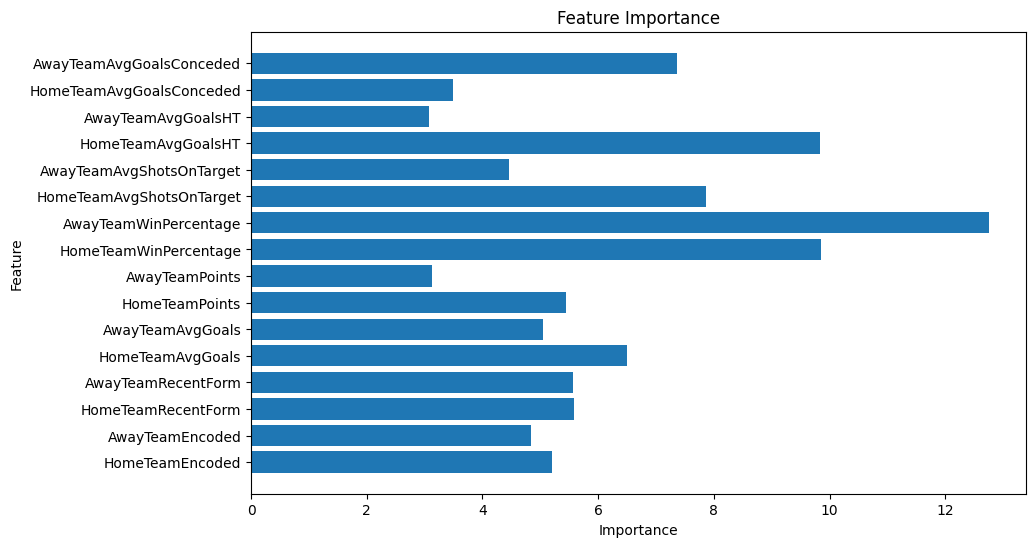

In [113]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = final_model.get_feature_importance()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [114]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, final_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsConceded'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsConceded'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = final_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = final_model.predict_proba(match_scaled)[0][2]
    draw_prob = final_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


print('##########################')
print('Today\'s matches')

predict_match('Fulham', 'Arsenal', final_model, scaler)

predict_match('Tottenham', 'Bournemouth', final_model, scaler)


##########################
Today's matches
Fulham win probability: 0.6849333811082833
Arsenal win probability: 0.18644691188697687
Draw probability: 0.12861970700473982
Tottenham win probability: 0.3537047180920326
Bournemouth win probability: 0.47745489050576323
Draw probability: 0.1688403914022042


(0.3537047180920326, 0.47745489050576323, 0.1688403914022042)

In [115]:
df_cleaned.isnull().sum().sum()

0

## Random Forest Classifier

In [116]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing Class Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit and transform the training data
X_train_imputed = imputer.fit_transform(X_train_smote)

# Transform the test data
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()

# Scale the imputed training data
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Scale the imputed test data
X_test_scaled = scaler.transform(X_test_imputed)


# Hyperparameter Tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', return_train_score=True)
grid_search.fit(X_train_scaled, y_train_smote)

# Accessing cross-validation results
cv_results = grid_search.cv_results_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.6254989916256287
              precision    recall  f1-score   support

           A       0.40      0.40      0.40        10
           D       0.50      0.43      0.46         7
           H       0.68      0.71      0.70        21

    accuracy                           0.58        38
   macro avg       0.53      0.51      0.52        38
weighted avg       0.57      0.58      0.58        38


In [117]:
# check for overfitting
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train_smote, cv=6)

# Print the average score
print(f"Average Cross-Validation Score: {cv_scores.mean()}")


Average Cross-Validation Score: 0.5757575757575757


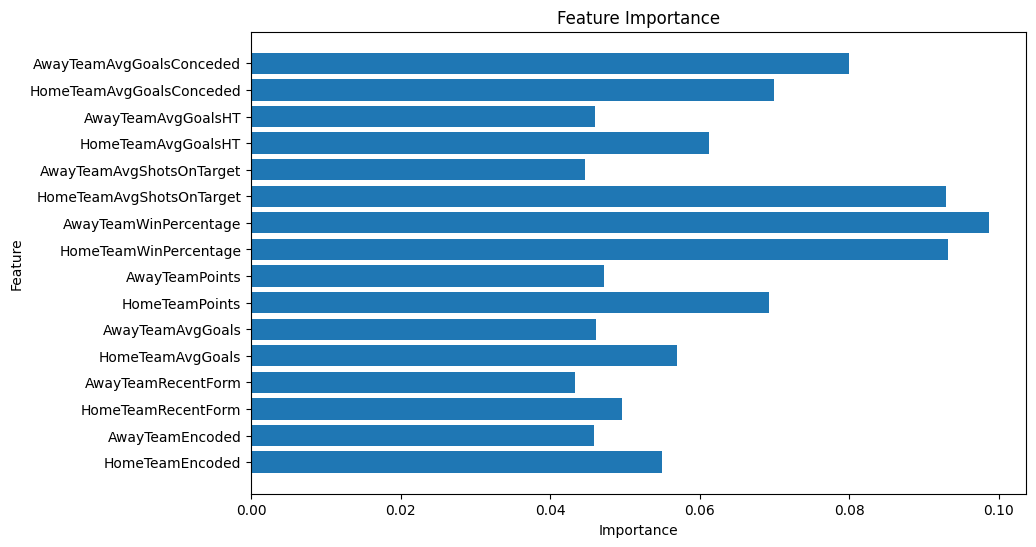

In [118]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [119]:
# sum of missing values or nan values
df_cleaned.isnull().sum().sum()

0

In [120]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, best_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsConceded'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsConceded'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = best_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = best_model.predict_proba(match_scaled)[0][2]
    draw_prob = best_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

print('Today\'s matches')

predict_match('Fulham', 'Arsenal', best_model, scaler)

predict_match('Tottenham', 'Bournemouth', best_model, scaler)




Today's matches
Fulham win probability: 0.771372180342008
Arsenal win probability: 0.11487679753196996
Draw probability: 0.11375102212602213
Tottenham win probability: 0.38672089947089955
Bournemouth win probability: 0.5321838624338625
Draw probability: 0.08109523809523808


C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(0.38672089947089955, 0.5321838624338625, 0.08109523809523808)

## withou

In [121]:
# now using xgb classifier
from hyperopt import hp

# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 1, 10),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10)
}


In [122]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder_y = LabelEncoder()

# Fit and transform the target variable using label_encoder_y
y_train_encoded = label_encoder_y.fit_transform(y_train_smote)
y_test_encoded = label_encoder_y.transform(y_test)


In [123]:
from hyperopt import STATUS_OK
from sklearn.metrics import accuracy_score
import xgboost as xgb

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    clf = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss', random_state=42, early_stopping_rounds=50)

    clf.fit(X_train_scaled, y_train_encoded, eval_set=[(X_test_scaled, y_test_encoded)], verbose=False)

    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}



In [124]:
# Trials object to store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 10/10 [00:00<00:00, 10.67trial/s, best loss: -0.5526315789473685]
Best hyperparameters: {'gamma': 0.959037185608874, 'learning_rate': 0.016278795632717585, 'max_depth': 6, 'min_child_weight': 6.232239083235662, 'n_estimators': 200.0, 'reg_alpha': 7.8631733968238375, 'reg_lambda': 6.975575990038505}


In [125]:
from sklearn.metrics import classification_report

# Get the best parameters
best_params = {k: int(v) if k in ['n_estimators', 'max_depth'] else v for k, v in best.items()}
print(best_params)


{'gamma': 0.959037185608874, 'learning_rate': 0.016278795632717585, 'max_depth': 6, 'min_child_weight': 6.232239083235662, 'n_estimators': 200, 'reg_alpha': 7.8631733968238375, 'reg_lambda': 6.975575990038505}


In [126]:
# Train the model with best parameters
xg_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xg_model.fit(X_train_scaled, y_train_encoded)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.959037185608874, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.016278795632717585, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6.232239083235662, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [127]:
# Evaluate the model
y_pred = xg_model.predict(X_test_scaled)
print(classification_report(y_test_encoded, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.18      0.29      0.22         7
           2       0.82      0.67      0.74        21

    accuracy                           0.55        38
   macro avg       0.50      0.48      0.49        38
weighted avg       0.62      0.55      0.58        38


In [128]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, xg_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsConceded'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsConceded'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = xg_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = xg_model.predict_proba(match_scaled)[0][2]
    draw_prob = xg_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob



print('##########################')
print('Today\'s matches')

predict_match('Fulham', 'Arsenal', xg_model, scaler)

predict_match('Tottenham', 'Bournemouth', xg_model, scaler)

##########################
Today's matches
Fulham win probability: 0.44813957810401917
Arsenal win probability: 0.3201299011707306
Draw probability: 0.23173050582408905
Tottenham win probability: 0.31145358085632324
Bournemouth win probability: 0.3994204103946686
Draw probability: 0.28912603855133057


C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\dagbo_b40tnyc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(0.31145358, 0.3994204, 0.28912604)

without using smote

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import xgboost as xgb
import numpy as np



# Select relevant columns or features and the target
features = [
    'HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 
    'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 
    'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 
    'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'
]
target = 'FTR'

# Split the data into training and test sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the LabelEncoder
label_encoder_y = LabelEncoder()

# Fit and transform the target variable using label_encoder_y
y_train_encoded = label_encoder_y.fit_transform(y_train)
y_test_encoded = label_encoder_y.transform(y_test)

# Define the hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.choice('max_depth', np.arange(3, 11, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 1, 10),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10)
}

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    clf = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss', random_state=42, early_stopping_rounds=10,)

    clf.fit(X_train_scaled, y_train_encoded, eval_set=[(X_test_scaled, y_test_encoded)], verbose=False)

    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

# Trials object to store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 10/10 [00:01<00:00,  8.04trial/s, best loss: -0.631578947368421]
Best hyperparameters: {'gamma': 0.812216872804228, 'learning_rate': 0.08341717516330023, 'max_depth': 2, 'min_child_weight': 4.732818796459157, 'n_estimators': 450.0, 'reg_alpha': 4.870079474711652, 'reg_lambda': 7.582336451658426}


In [130]:
# evaluate the model
from sklearn.metrics import classification_report

# Get the best parameters
best_params = {k: int(v) if k in ['n_estimators', 'max_depth'] else v for k, v in best.items()}
print(best_params)

# Train the model with best parameters
xg_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xg_model.fit(X_train_scaled, y_train_encoded)

# Evaluate the model
y_pred = xg_model.predict(X_test_scaled)

print(classification_report(y_test_encoded, y_pred, zero_division=0))

{'gamma': 0.812216872804228, 'learning_rate': 0.08341717516330023, 'max_depth': 2, 'min_child_weight': 4.732818796459157, 'n_estimators': 450, 'reg_alpha': 4.870079474711652, 'reg_lambda': 7.582336451658426}
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        10
           1       0.00      0.00      0.00         7
           2       0.72      0.86      0.78        21

    accuracy                           0.63        38
   macro avg       0.39      0.49      0.43        38
weighted avg       0.52      0.63      0.57        38


In [131]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, xg_model, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'])
    match.loc[0] = [label_encoder.transform([home_team])[0], label_encoder.transform([away_team])[0], calculate_form_points(home_team, df_cleaned), calculate_form_points(away_team, df_cleaned), df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].values[0], calculate_team_points(home_team, df_cleaned), calculate_team_points(away_team, df_cleaned), home_team_win_percentage[home_team], away_team_win_percentage[away_team], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].values[0], df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsConceded'].values[0], df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsConceded'].values[0]]
    # Scale the features
    match_scaled = scaler.transform(match)
    # Make predictions
    home_team_win_prob = xg_model.predict_proba(match_scaled)[0][0]
    away_team_win_prob = xg_model.predict_proba(match_scaled)[0][2]
    draw_prob = xg_model.predict_proba(match_scaled)[0][1]
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob

# brighton vs tottenham

predict_match('Brighton', 'Tottenham', xg_model, scaler)

# arsenal vs west ham
predict_match('Arsenal', 'West Ham', xg_model, scaler)

print('##########################')
print('Today\'s matches')

predict_match('Fulham', 'Arsenal', xg_model, scaler)

predict_match('Tottenham', 'Bournemouth', xg_model, scaler)


Brighton win probability: 0.29678305983543396
Tottenham win probability: 0.46865904331207275
Draw probability: 0.2345578819513321
Arsenal win probability: 0.2761107385158539
West Ham win probability: 0.5056694746017456
Draw probability: 0.2182198017835617
##########################
Today's matches
Fulham win probability: 0.4622405171394348
Arsenal win probability: 0.37258443236351013
Draw probability: 0.16517505049705505
Tottenham win probability: 0.2938273251056671
Bournemouth win probability: 0.5040632486343384
Draw probability: 0.2021094262599945


(0.29382733, 0.50406325, 0.20210943)

In [132]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

# Using the best parameters obtained from hyperparameter tuning
best_params_catboost = {
    'iterations': 400,
    'depth': 6,
    'learning_rate': 0.07913495587122336,
    'l2_leaf_reg': 8.599126083224103,
    'bagging_temperature': 0.6364763408110247,
    'random_strength': 0.9024923769287154
}

# Initialize CatBoost Classifier with the best parameters
catboost_model = CatBoostClassifier(**best_params_catboost, loss_function='MultiClass', eval_metric='Accuracy', verbose=False)

# Train the model on the original dataset (without SMOTE)
catboost_model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), early_stopping_rounds=50)

# Predict on the test set
y_pred_catboost = catboost_model.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred_catboost, zero_division=0))


              precision    recall  f1-score   support

           A       0.45      0.50      0.48        10
           D       0.00      0.00      0.00         7
           H       0.70      0.90      0.79        21

    accuracy                           0.63        38
   macro avg       0.39      0.47      0.42        38
weighted avg       0.51      0.63      0.56        38


In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Use the best parameters previously obtained
best_params_rf = {
    'n_estimators': 300,  # Example value
    'max_depth': 10,      # Example value
    'min_samples_split': 2,  # Example value
    'min_samples_leaf': 1  # Example value
}

# Initialize RandomForest Classifier with the best parameters
rf_model = RandomForestClassifier(**best_params_rf, random_state=42)

# Train the model on the original dataset (without SMOTE)
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           A       0.36      0.40      0.38        10
           D       0.25      0.14      0.18         7
           H       0.65      0.71      0.68        21

    accuracy                           0.53        38
   macro avg       0.42      0.42      0.41        38
weighted avg       0.50      0.53      0.51        38


In [134]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

# Initialize the VotingClassifier
voting_clf = VotingClassifier(estimators=[('catboost', catboost_model), ('xg', xg_model)], voting='soft')

print(voting_clf)
# Train the voting classifier on the original dataset (without SMOTE)
voting_clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_voting = voting_clf.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred_voting))



VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000019B14CC6990>),
                             ('xg',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            gamma=0.81...
                                            interaction_constraints=None,
                                            learning_rate=0.0834171751

In [135]:
# make predictions for the 2023/24 season
def predict_match(home_team, away_team, voting_clf, scaler):
    # Create a dataframe with the appropriate format
    match = pd.DataFrame(columns=['HomeTeamEncoded', 'AwayTeamEncoded', 'HomeTeamRecentForm', 'AwayTeamRecentForm', 'HomeTeamAvgGoals', 'AwayTeamAvgGoals', 'HomeTeamPoints', 'AwayTeamPoints', 'HomeTeamWinPercentage', 'AwayTeamWinPercentage', 'HomeTeamAvgShotsOnTarget', 'AwayTeamAvgShotsOnTarget', 'HomeTeamAvgGoalsHT', 'AwayTeamAvgGoalsHT', 'HomeTeamAvgGoalsConceded', 'AwayTeamAvgGoalsConceded'])
    
    # Populate the match dataframe with values from the cleaned dataset
    match.loc[0] = [
        label_encoder.transform([home_team])[0], 
        label_encoder.transform([away_team])[0], 
        calculate_form_points(home_team, df_cleaned), 
        calculate_form_points(away_team, df_cleaned), 
        df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoals'].mean(), 
        df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoals'].mean(), 
        calculate_team_points(home_team, df_cleaned), 
        calculate_team_points(away_team, df_cleaned), 
        home_team_win_percentage[home_team], 
        away_team_win_percentage[away_team], 
        df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgShotsOnTarget'].mean(), 
        df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgShotsOnTarget'].mean(), 
        df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsHT'].mean(), 
        df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsHT'].mean(),
        df_cleaned[df_cleaned['HomeTeam'] == home_team]['HomeTeamAvgGoalsConceded'].mean(),
        df_cleaned[df_cleaned['AwayTeam'] == away_team]['AwayTeamAvgGoalsConceded'].mean()
    ]
    
    # Check for NaN values and handle them with imputer
    match_imputed = imputer.transform(match)
    
    # Scale the features
    match_scaled = scaler.transform(match)
    
    # Make predictions
    home_team_win_prob = voting_clf.predict_proba(match_scaled)[0][0]
    away_team_win_prob = voting_clf.predict_proba(match_scaled)[0][2]
    draw_prob = voting_clf.predict_proba(match_scaled)[0][1]
    
    # Print the results
    print(f"{home_team} win probability: {home_team_win_prob}")
    print(f"{away_team} win probability: {away_team_win_prob}")
    print(f"Draw probability: {draw_prob}")
    
    return home_team_win_prob, away_team_win_prob, draw_prob


print('Today\'s matches')

predict_match('Fulham', 'Arsenal', voting_clf, scaler)

predict_match('Tottenham', 'Bournemouth', voting_clf, scaler)


Today's matches
Fulham win probability: 0.642501076084547
Arsenal win probability: 0.2179924107469058
Draw probability: 0.13950651316854715
Tottenham win probability: 0.41093975917852926
Bournemouth win probability: 0.448663297051928
Draw probability: 0.14039694376954276


(0.41093975917852926, 0.448663297051928, 0.14039694376954276)